# Instructions for Damien and Ros

### please run all cells marked with a * before them, and all cells for parts I have allotted you
I will be running the text + image modality one

- Ros: please run text modality
- Damien: please run image modality

# *Imports

In [52]:
import os
import sys
import itertools
from collections import defaultdict

import scipy.sparse as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from adjustText import adjust_text

from PIL import Image
import requests
from io import BytesIO

import cornac
from cornac.utils import cache
from cornac.data import Dataset
from cornac.eval_methods import RatioSplit
from cornac.models import MF, WMF, EASE, CTR
from cornac.models.dmrl import DMRL
from cornac.data import TextModality
from cornac.data.text import BaseTokenizer

import tensorflow as tf
import torch

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = False

System version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:27:10) [MSC v.1938 64 bit (AMD64)]
Cornac version: 2.2.1
Tensorflow version: 2.16.1


# *Load dataset

In [14]:
ratings_path = '../data/01_raw/rating.csv'
anime_path = '../data/03_primary/anime_final_cleaned.csv'

In [17]:
ratings = pd.read_csv(ratings_path)
content = pd.read_csv(anime_path)

In [18]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [19]:
content.sort_values(by="anime_id", inplace=True)

In [20]:
content.head()

,anime_id,name,type,episodes,mal_score,members,studio,release-season,release-year,release-date,...,themes,demographics,synopsis,image_url,rating,va_list,staff_list,recommended_review_count,mixedfeelings_review_count,notrecommended_review_count
22,1,Cowboy Bebop,TV,26,8.82,486824,['Sunrise'],spring,1998.0,NaN,...,[],NaN,"Crime is timeless. By the year 2071, humanity ...",https://cdn.myanimelist.net/images/anime/4/196...,R - 17+ (violence & profanity),"['Yamadera, Kouichi', 'Hayashibara, Megumi', '...","['Cook, Justin', 'Maseba, Yutaka', 'Minami, Ma...",539.0,38.0,17.0
147,5,Cowboy Bebop: Tengoku no Tobira,Movie,1,8.40,137636,['Bones'],summer,2001.0,NaN,...,[],NaN,"Another day, another bounty—such is the life o...",https://cdn.myanimelist.net/images/anime/1439/...,R - 17+ (violence & profanity),"['Yamadera, Kouichi', 'Hayashibara, Megumi', '...","['Maseba, Yutaka', 'Minami, Masahiko', 'Ueda, ...",62.0,8.0,3.0
208,6,Trigun,TV,26,8.32,283069,['Madhouse'],spring,1998.0,NaN,...,['Adult Cast'],Shounen,"Vash the Stampede is the man with a $$60,000,0...",https://cdn.myanimelist.net/images/anime/7/203...,PG-13 - Teens 13 or older,"['Onosaka, Masaya', 'Hayami, Show', 'Yukino, S...","['Cook, Justin', 'Maseba, Yutaka', 'Kitayama, ...",151.0,16.0,9.0
2050,7,Witch Hunter Robin,TV,26,7.36,64905,['Sunrise'],summer,2002.0,NaN,...,[],NaN,Robin Sena is a powerful craft user drafted in...,https://cdn.myanimelist.net/images/anime/10/19...,PG-13 - Teens 13 or older,"['Watanabe, Akeno', 'Takewaka, Takuma', 'Yuuki...","['Murase, Shukou', 'Fujino, Sadayoshi', 'Miyat...",28.0,6.0,4.0
3090,8,Beet the Vandel Buster,TV,52,7.06,9848,['Toei Animation'],fall,2004.0,NaN,...,[],NaN,It is the dark century and the people are suff...,https://cdn.myanimelist.net/images/anime/7/215...,PG - Children,"['Kiuchi, Reiko', 'Hisakawa, Aya', 'Miura, Hir...","['Seki, Hiromi', 'Nagamine, Tatsuya', 'Yamauch...",3.0,1.0,0.0


# *Preprocessing

In [21]:
# clean user_id
all_users = ratings['user_id'].unique()
print(f"number of users = {len(all_users)}")

number of users = 73515


In [22]:
print(f"user_id ranges from: {ratings['user_id'].min()} to {ratings['user_id'].max()}")

user_id ranges from: 1 to 73516


There is a single missing user_id within the range. To remap the user_ids.

In [23]:
max = ratings['user_id'].max()
# use property of arithmetic series :) (thanks leetcode! O(1))
missing = (max * (max+1)) / 2 - all_users.sum()
missing

46809.0

In [24]:
# double check whether that really is the missing user_id
id_46809_in_users = 46809 in all_users
id_46809_in_users

False

In [25]:
# double check whether all other values are present in the column. O(n)
all_users_set = set(all_users)
all_others_present = True
for user in range(1, ratings['user_id'].max() + 1):
    if user == 46809:
        continue
    else:
        if user in all_users_set:
            continue
        all_others_present = False
        break
    
all_others_present

True

In [12]:
# instead of remapping the entire user_id column, we can just change last user 73516 to 46809.
ratings[ratings["user_id"]==73516]

,user_id,anime_id,rating
7807793,73516,790,9
7807794,73516,8074,9


In [26]:
ratings["user_id"] = ratings["user_id"].replace(73516, 46809)
ratings[ratings["user_id"]==46809]

,user_id,anime_id,rating
7813735,46809,790,9
7813736,46809,8074,9


In [27]:
# discard ratings for items not in final anime list
filtered_ratings = pd.merge(
    content, 
    ratings, 
    on="anime_id", 
    how="left", 
    suffixes=["_left", ""]
)[["user_id", "anime_id", "rating"]].sort_values(by=['user_id'])

filtered_ratings

,user_id,anime_id,rating
4458436,1,8407,-1
5764696,1,13411,-1
4946889,1,10073,-1
5755528,1,13367,-1
4950590,1,10076,-1
...,...,...,...
2349703,73515,1818,9
1038389,73515,411,9
5471551,73515,11751,6
4172236,73515,6919,7


In [28]:
# find out how many ratings were lost due to missing synopsis and/or cover image
print(f"lost ratings due to missing synopsis and/or cover image {len(ratings) - len(filtered_ratings)}")

lost ratings due to missing synopsis and/or cover image 6063


In [29]:
# reindex items
anime_remap = {}
sorted_content = content.sort_values(by=['anime_id'])
all_anime = sorted_content['anime_id'].unique()

counter = 1
for anime in all_anime:
    anime_remap[anime] = counter
    counter += 1

content["anime_id_remapped"] = content["anime_id"].map(anime_remap)
content.head()

,anime_id,name,type,episodes,mal_score,members,studio,release-season,release-year,release-date,...,demographics,synopsis,image_url,rating,va_list,staff_list,recommended_review_count,mixedfeelings_review_count,notrecommended_review_count,anime_id_remapped
22,1,Cowboy Bebop,TV,26,8.82,486824,['Sunrise'],spring,1998.0,NaN,...,NaN,"Crime is timeless. By the year 2071, humanity ...",https://cdn.myanimelist.net/images/anime/4/196...,R - 17+ (violence & profanity),"['Yamadera, Kouichi', 'Hayashibara, Megumi', '...","['Cook, Justin', 'Maseba, Yutaka', 'Minami, Ma...",539.0,38.0,17.0,1
147,5,Cowboy Bebop: Tengoku no Tobira,Movie,1,8.40,137636,['Bones'],summer,2001.0,NaN,...,NaN,"Another day, another bounty—such is the life o...",https://cdn.myanimelist.net/images/anime/1439/...,R - 17+ (violence & profanity),"['Yamadera, Kouichi', 'Hayashibara, Megumi', '...","['Maseba, Yutaka', 'Minami, Masahiko', 'Ueda, ...",62.0,8.0,3.0,2
208,6,Trigun,TV,26,8.32,283069,['Madhouse'],spring,1998.0,NaN,...,Shounen,"Vash the Stampede is the man with a $$60,000,0...",https://cdn.myanimelist.net/images/anime/7/203...,PG-13 - Teens 13 or older,"['Onosaka, Masaya', 'Hayami, Show', 'Yukino, S...","['Cook, Justin', 'Maseba, Yutaka', 'Kitayama, ...",151.0,16.0,9.0,3
2050,7,Witch Hunter Robin,TV,26,7.36,64905,['Sunrise'],summer,2002.0,NaN,...,NaN,Robin Sena is a powerful craft user drafted in...,https://cdn.myanimelist.net/images/anime/10/19...,PG-13 - Teens 13 or older,"['Watanabe, Akeno', 'Takewaka, Takuma', 'Yuuki...","['Murase, Shukou', 'Fujino, Sadayoshi', 'Miyat...",28.0,6.0,4.0,4
3090,8,Beet the Vandel Buster,TV,52,7.06,9848,['Toei Animation'],fall,2004.0,NaN,...,NaN,It is the dark century and the people are suff...,https://cdn.myanimelist.net/images/anime/7/215...,PG - Children,"['Kiuchi, Reiko', 'Hisakawa, Aya', 'Miura, Hir...","['Seki, Hiromi', 'Nagamine, Tatsuya', 'Yamauch...",3.0,1.0,0.0,5


In [30]:
filtered_ratings["anime_id_remapped"] = filtered_ratings["anime_id"].map(anime_remap)
filtered_ratings.head()

,user_id,anime_id,rating,anime_id_remapped
4458436,1,8407,-1,5329
5764696,1,13411,-1,6921
4946889,1,10073,-1,6016
5755528,1,13367,-1,6910
4950590,1,10076,-1,6019


In [31]:
# map came from content dataframe, double check if filtered_ratings was remapped properly
filtered_ratings["anime_id_remapped"].isna().sum()

0

In [32]:
# take only the columns we want
ratings_cleaned = filtered_ratings[["user_id", "anime_id_remapped", "rating"]]

# *Explore different encodings
Encoding "Watched but not rated" as -1 may cause such anime to be devalued as compared to unwatched anime. Plan to explore different encoding representations

- leave "watched but not rated" as -1
- convert them to 0.5 (just above unwatched, but that means less value than a 1 star anime)
- convert them to 5 (middle of the scale, but everyone's middle may be different)
- convert them to 7 (just below the "high" ratings)

It may also be valuable to explore if binning scores can improve the rec sys

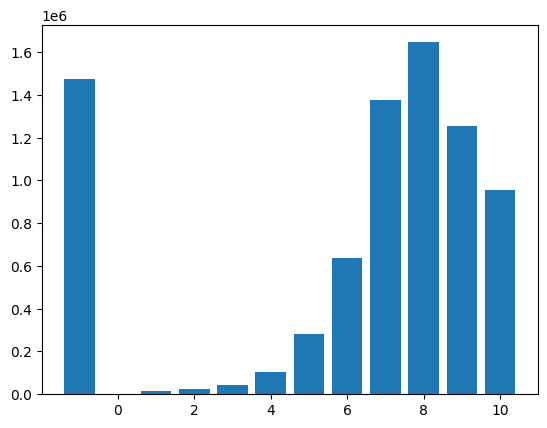

In [33]:
ratings_vc = ratings_cleaned["rating"].value_counts().sort_index()
rating_values, rating_counts = list(ratings_vc.index), list(ratings_vc.values)
plt.bar(rating_values, rating_counts)
plt.show()

Users tend to rate anime with fairly high ratings, the most comming rating is 8. Ratings above 7 make up the majority of ratings. A sizable portion of interations are unrated.

In [20]:
# count number of unrated interactions
# all_minus1 = ratings_cleaned[ratings_cleaned["rating"]==-1]
# len(all_minus1)

In [21]:
# users_no_rating = all_minus1["user_id"].unique()
# len(users_no_rating)

roughly half of our users have at least 1 unrated anime.

In [22]:
# users_who_never_rate = []
# for user in users_no_rating:
#     all_their_ratings = ratings_cleaned[ratings_cleaned["user_id"]==user]["rating"].unique()
#     if len(all_their_ratings) == 1:
#         users_who_never_rate.append(user)

# len(users_who_never_rate)

There is a population of users who have never rated but it is a small population out of the users who have at least one "watched but not rated" anime. I don't think it's worth executing anything special for them.

In [34]:
ratings_point5 = ratings_cleaned.copy(deep=True)
ratings_5 = ratings_cleaned.copy(deep=True)
ratings_7 = ratings_cleaned.copy(deep=True)

ratings_point5["rating"] = ratings_point5["rating"].replace(-1, 0.5)
ratings_5["rating"] = ratings_5["rating"].replace(-1, 5)
ratings_7["rating"] = ratings_7["rating"].replace(-1, 7)

### *Save to csv (if you have not already done so)

In [24]:
# Save these options to csv
# ratings_point5.to_csv("../data/05_model_input/ratings_point5.csv", index=False)
# ratings_5.to_csv("../data/05_model_input/ratings_5.csv", index=False)
# ratings_7.to_csv("../data/05_model_input/ratings_7.csv", index=False)

In [ ]:
# Code to load the csvs back to dataframe
# ratings_point5 = pd.read_csv("../data/05_model_input/ratings_point5.csv")
# ratings_5 = pd.read_csv("../data/05_model_input/ratings_5.csv")
# ratings_7 = pd.read_csv("../data/05_model_input/ratings_7.csv")

### *Convert ratings data 

In [35]:
# Convert user id and anime id to strings for ratings_7
ratings_7['user_id'] = ratings_7['user_id'].astype('str')
ratings_7['anime_id_remapped'] = ratings_7['anime_id_remapped'].astype('str')

In [36]:
# convert data into list of tuples
# this version of the data did not change the -1 values
ratings_data = [tuple(row) for row in ratings_cleaned.itertuples(index=False)]
ratings_point5_data = [tuple(row) for row in ratings_point5.itertuples(index=False)]
ratings_5_data = [tuple(row) for row in ratings_5.itertuples(index=False)]
ratings_7_data = [tuple(row) for row in ratings_7.itertuples(index=False)]

In [37]:
# inspect ratings_7_data

for uir in ratings_7_data:
    print(uir)
    break

('1', '5329', 7)


# *Model Baselines (Ratings data only)

## -------------------
## Damien and Ros!!!
## -------------------

only run the next cell in this section to define eval metrics

In [38]:
# mf10 = MF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.01, use_bias=False,
#         verbose=VERBOSE, seed=SEED, name=f"MF(K=10)")
# wmf10 = WMF(k=10, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
#           verbose=VERBOSE, seed=SEED, name=f"WMF(K=10)")
# mf50 = MF(k=50, max_iter=100, learning_rate=0.001, lambda_reg=0.01, use_bias=False,
#         verbose=VERBOSE, seed=SEED, name=f"MF(K=50)")
# wmf50 = WMF(k=50, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
#           verbose=VERBOSE, seed=SEED, name=f"WMF(K=50)")
# mf100 = MF(k=100, max_iter=100, learning_rate=0.001, lambda_reg=0.01, use_bias=False,
#         verbose=VERBOSE, seed=SEED, name=f"MF(K=100)")
# wmf100 = WMF(k=100, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
#           verbose=VERBOSE, seed=SEED, name=f"WMF(K=100)")



eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=20),
  cornac.metrics.Recall(k=20),
  cornac.metrics.FMeasure(k=20),
  cornac.metrics.NDCG(k=20),
  cornac.metrics.NCRR(k=20),
  cornac.metrics.Precision(k=50),
  cornac.metrics.Recall(k=50),
  cornac.metrics.FMeasure(k=50),
  cornac.metrics.NDCG(k=50),
  cornac.metrics.NCRR(k=50),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]

### Unrated = -1

In [104]:
rs = RatioSplit(ratings_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[
        mf10, wmf10,
        mf50, wmf50,
        mf100, wmf100], metrics=eval_metrics).run()

c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\models\recommender.py:306: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(



TEST:
...
           |   RMSE |    AUC |  F1@20 |  F1@50 |    MAP |    MRR | NCRR@20 | NCRR@50 | NDCG@20 | NDCG@50 | Precision@20 | Precision@50 | Recall@20 | Recall@50 | Train (s) |  Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------------ + ------------ + --------- + --------- + --------- + ---------
MF(K=10)   | 1.7657 | 0.8386 | 0.0227 | 0.0268 | 0.0281 | 0.0939 |  0.0388 |  0.0411 |  0.0427 |  0.0541 |       0.0256 |       0.0220 |    0.0468 |    0.0874 |   53.3032 |  821.1504
WMF(K=10)  | 2.9126 | 0.9429 | 0.1091 | 0.1112 | 0.1156 | 0.3346 |  0.1755 |  0.1821 |  0.1821 |  0.2173 |       0.1168 |       0.0877 |    0.1821 |    0.3084 | 2929.6227 |  554.2180
MF(K=50)   | 1.8317 | 0.8485 | 0.0360 | 0.0375 | 0.0443 | 0.1523 |  0.0676 |  0.0702 |  0.0727 |  0.0874 |       0.0379 |       0.0298 |    0.0802 |    0.1339 |  234.4542 | 1027.7630
WMF(K=50)  | 2.8600 | 0.9505 | 0.1130 | 0.1149 | 0.1237 | 0.3616 |  0.1903

### Unrated = 0.5

In [105]:
rs = RatioSplit(ratings_point5_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[
        mf10, wmf10,
        mf50, wmf50,
        mf100, wmf100], metrics=eval_metrics).run()


TEST:
...
           |   RMSE |    AUC |  F1@20 |  F1@50 |    MAP |    MRR | NCRR@20 | NCRR@50 | NDCG@20 | NDCG@50 | Precision@20 | Precision@50 | Recall@20 | Recall@50 | Train (s) | Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------------ + ------------ + --------- + --------- + --------- + --------
MF(K=10)   | 1.6091 | 0.8377 | 0.0188 | 0.0232 | 0.0239 | 0.0760 |  0.0305 |  0.0326 |  0.0346 |  0.0450 |       0.0216 |       0.0193 |    0.0391 |    0.0754 |   50.4856 | 752.1639
WMF(K=10)  | 2.6952 | 0.9697 | 0.1169 | 0.1184 | 0.1281 | 0.3558 |  0.1905 |  0.1981 |  0.1984 |  0.2373 |       0.1233 |       0.0929 |    0.2027 |    0.3393 | 2634.4292 | 461.5037
MF(K=50)   | 1.7170 | 0.8422 | 0.0276 | 0.0297 | 0.0374 | 0.1167 |  0.0519 |  0.0544 |  0.0580 |  0.0708 |       0.0292 |       0.0239 |    0.0676 |    0.1134 |  192.9291 | 720.4256
WMF(K=50)  | 2.6045 | 0.9716 | 0.1276 | 0.1284 | 0.1439 | 0.3845 |  0.2105 |  0

### Unrated = 5

In [112]:
rs = RatioSplit(ratings_5_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[
        mf10, wmf10,
        mf50, wmf50, 
        mf100, wmf100], metrics=eval_metrics).run()

c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\models\recommender.py:306: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(



TEST:
...
           |   RMSE |    AUC |  F1@20 |  F1@50 |    MAP |    MRR | NCRR@20 | NCRR@50 | NDCG@20 | NDCG@50 | Precision@20 | Precision@50 | Recall@20 | Recall@50 | Train (s) |  Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------------ + ------------ + --------- + --------- + --------- + ---------
MF(K=10)   | 1.1821 | 0.8191 | 0.0167 | 0.0222 | 0.0201 | 0.0581 |  0.0223 |  0.0249 |  0.0281 |  0.0381 |       0.0207 |       0.0193 |    0.0320 |    0.0651 |   59.7835 |  981.5862
WMF(K=10)  | 2.5207 | 0.9710 | 0.1260 | 0.1315 | 0.1376 | 0.3836 |  0.2065 |  0.2142 |  0.2119 |  0.2517 |       0.1385 |       0.1057 |    0.2031 |    0.3446 | 2798.9323 |  590.5558
MF(K=50)   | 1.2749 | 0.8354 | 0.0257 | 0.0284 | 0.0345 | 0.1109 |  0.0480 |  0.0504 |  0.0532 |  0.0652 |       0.0280 |       0.0233 |    0.0594 |    0.1026 |  214.9807 |  987.6285
WMF(K=50)  | 2.4418 | 0.9735 | 0.1400 | 0.1429 | 0.1583 | 0.4134 |  0.2291

### Unrated = 7

In [113]:
rs = RatioSplit(ratings_7_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[
        mf10, wmf10,
        mf50, wmf50,
        mf100, wmf100], metrics=eval_metrics).run()

c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\data\dataset.py:335: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\User\anaconda3\envs\CS608_RecommenderSystems\lib\site-packages\cornac\models\recommender.py:306: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(



TEST:
...
           |   RMSE |    AUC |  F1@20 |  F1@50 |    MAP |    MRR | NCRR@20 | NCRR@50 | NDCG@20 | NDCG@50 | Precision@20 | Precision@50 | Recall@20 | Recall@50 | Train (s) |  Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------- + ------------ + ------------ + --------- + --------- + --------- + ---------
MF(K=10)   | 1.0463 | 0.8119 | 0.0132 | 0.0195 | 0.0164 | 0.0390 |  0.0136 |  0.0166 |  0.0200 |  0.0303 |       0.0167 |       0.0170 |    0.0247 |    0.0558 |   80.1222 | 1100.2063
WMF(K=10)  | 2.6701 | 0.9707 | 0.1273 | 0.1327 | 0.1397 | 0.3888 |  0.2096 |  0.2173 |  0.2139 |  0.2539 |       0.1397 |       0.1067 |    0.2029 |    0.3444 | 3293.1244 |  656.9865
MF(K=50)   | 1.1278 | 0.8322 | 0.0234 | 0.0260 | 0.0326 | 0.1014 |  0.0441 |  0.0463 |  0.0492 |  0.0604 |       0.0257 |       0.0215 |    0.0554 |    0.0958 |  228.2291 |  994.2652
WMF(K=50)  | 2.4631 | 0.9739 | 0.1452 | 0.1480 | 0.1671 | 0.4193 |  0.2358

### Unrated = 7 appears to give the best predictions on ranking based metrics
### K=100 appears to give the best ranking based results

In [23]:
dmrl100 = DMRL(batch_size=128, epochs=5, log_metrics=False, learning_rate=0.01, num_factors=2, 
        decay_r=0.5, decay_c=0.01, num_neg=3, embedding_dim=100, name='dmrl(emb_dim=100)')

In [31]:
rs = RatioSplit(ratings_7_data, test_size=0.2, seed=SEED, verbose=VERBOSE)

# cornac.Experiment(eval_method=rs, models=[
#         ease100, dmrl100], metrics=eval_metrics).run()
cornac.Experiment(eval_method=rs, models=[
        dmrl100], metrics=eval_metrics).run()

KeyboardInterrupt: 

### Text Modality (Ros)

#### 
Preprocessing labels: We perform feature selection using domain expertise, and have identified the following labels to be important info: 
- genre
- themes
- source-material
- demographics
- rating (age rating eg. R-17+ Violence and profanity)

anime genre

In [137]:
print('Null values in genres:', content['genres'].isna().sum())
content['genres'] = content['genres'].fillna('missing genre')
content['genres_string'] = content['genres'].astype(str).str.strip('[]').str.replace("'","").str.join('').str.lower()
# inspect genre string
content['genres_string'].head()

Null values in genres: 0


22                            action, sci-fi
147                           action, sci-fi
208                action, adventure, sci-fi
2050    action, drama, mystery, supernatural
3090        adventure, fantasy, supernatural
Name: genres_string, dtype: object

anime themes

In [141]:
print('Null values in themes:', content['themes'].isna().sum())
content['themes'] = content['themes'].fillna('missing themes')
content['themes'] = content['themes'].replace("[]","missing themes")
content['themes_string'] = content['themes'].astype(str).str.strip('[]').str.replace("'","").str.join('').str.lower()
# inspect themes string
content['themes_string'].head()

Null values in themes: 0


22      missing themes
147     missing themes
208         adult cast
2050    missing themes
3090    missing themes
Name: themes_string, dtype: object

anime source-material

In [154]:
print('Null values in source-material:', content['source-material'].isna().sum())
content['source-material'] = content['source-material'].fillna('missing source-material')
content['source-material'] = content['source-material'].str.lower()
content['source-material'].head()

Null values in source-material: 0


22      original
147     original
208        manga
2050    original
3090       manga
Name: source-material, dtype: object

anime demographics

In [153]:
print('Null values in demographics:', content['demographics'].isna().sum())
content['demographics'] = content['demographics'].fillna('missing demographics')
content['demographics'] = content['demographics'].str.lower()
content['demographics'].head()

Null values in demographics: 0


22      missing demographics
147     missing demographics
208                  shounen
2050    missing demographics
3090    missing demographics
Name: demographics, dtype: object

anime rating

In [159]:
print('Null values in rating:', content['rating'].isna().sum())
content['rating'] = content['rating'].fillna('missing rating')
content['rating'].head()

Null values in rating: 153


22      R - 17+ (violence & profanity)
147     R - 17+ (violence & profanity)
208          PG-13 - Teens 13 or older
2050         PG-13 - Teens 13 or older
3090                     PG - Children
Name: rating, dtype: object

anime synopsis

In [39]:
docs = list(content["synopsis"])

In [40]:
item_ids = list(content["anime_id_remapped"])

In [41]:
content

,anime_id,name,type,episodes,mal_score,members,studio,release-season,release-year,release-date,...,demographics,synopsis,image_url,rating,va_list,staff_list,recommended_review_count,mixedfeelings_review_count,notrecommended_review_count,anime_id_remapped
22,1,Cowboy Bebop,TV,26,8.82,486824,['Sunrise'],spring,1998.0,NaN,...,NaN,"Crime is timeless. By the year 2071, humanity ...",https://cdn.myanimelist.net/images/anime/4/196...,R - 17+ (violence & profanity),"['Yamadera, Kouichi', 'Hayashibara, Megumi', '...","['Cook, Justin', 'Maseba, Yutaka', 'Minami, Ma...",539.0,38.0,17.0,1
147,5,Cowboy Bebop: Tengoku no Tobira,Movie,1,8.40,137636,['Bones'],summer,2001.0,NaN,...,NaN,"Another day, another bounty—such is the life o...",https://cdn.myanimelist.net/images/anime/1439/...,R - 17+ (violence & profanity),"['Yamadera, Kouichi', 'Hayashibara, Megumi', '...","['Maseba, Yutaka', 'Minami, Masahiko', 'Ueda, ...",62.0,8.0,3.0,2
208,6,Trigun,TV,26,8.32,283069,['Madhouse'],spring,1998.0,NaN,...,Shounen,"Vash the Stampede is the man with a $$60,000,0...",https://cdn.myanimelist.net/images/anime/7/203...,PG-13 - Teens 13 or older,"['Onosaka, Masaya', 'Hayami, Show', 'Yukino, S...","['Cook, Justin', 'Maseba, Yutaka', 'Kitayama, ...",151.0,16.0,9.0,3
2050,7,Witch Hunter Robin,TV,26,7.36,64905,['Sunrise'],summer,2002.0,NaN,...,NaN,Robin Sena is a powerful craft user drafted in...,https://cdn.myanimelist.net/images/anime/10/19...,PG-13 - Teens 13 or older,"['Watanabe, Akeno', 'Takewaka, Takuma', 'Yuuki...","['Murase, Shukou', 'Fujino, Sadayoshi', 'Miyat...",28.0,6.0,4.0,4
3090,8,Beet the Vandel Buster,TV,52,7.06,9848,['Toei Animation'],fall,2004.0,NaN,...,NaN,It is the dark century and the people are suff...,https://cdn.myanimelist.net/images/anime/7/215...,PG - Children,"['Kiuchi, Reiko', 'Hisakawa, Aya', 'Miura, Hir...","['Seki, Hiromi', 'Nagamine, Tatsuya', 'Yamauch...",3.0,1.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6583,34367,Long Riders Recap,Special,1,5.97,582,['Actas'],fall,2016.0,NaN,...,Shounen,Recap of the first four episodes of the series.,https://cdn.myanimelist.net/images/anime/11/82...,PG-13 - Teens 13 or older,[],[],0.0,0.0,0.0,11090
8405,34412,Hashiri Hajimeta bakari no Kimi ni,Music,1,6.76,239,NaN,NaN,NaN,NaN,...,NaN,"Animated music video for , the third single o...",https://cdn.myanimelist.net/images/anime/2/829...,PG-13 - Teens 13 or older,"['Terakawa, Aimi', 'Itou, Ayasa', 'Ohashi, Aya...","['Agematsu, Noriyasu', 'Nakamura, Kou']",0.0,0.0,0.0,11091
4893,34475,Monster Strike: Rain of Memories,ONA,1,6.58,313,"['Connect', 'Ultra Super Pictures']",fall,2016.0,NaN,...,NaN,- They deserve better. Someone better than me....,https://cdn.myanimelist.net/images/anime/1460/...,PG-13 - Teens 13 or older,"['Lynn', 'Kimura, Juri', 'Ono, Daisuke', 'Kawa...","['Ichikawa, Kazuya', 'Tachibana, Hideki', 'WHI...",0.0,0.0,0.0,11092
9288,34476,Platonic Chain: Ansatsu Jikkouchuu,Special,1,1.67,51,['Unknown'],summer,2005.0,NaN,...,NaN,"A DVD-only story that replaces episode 16 (""Oy...",https://cdn.myanimelist.net/images/anime/8/831...,PG-13 - Teens 13 or older,[],[],0.0,0.0,0.0,11093


In [42]:
# inspect item ids

for id in item_ids:
    print(type(id))
    print(id)
    break

<class 'int'>
1


In [45]:
# item_text_modality = TextModality(corpus=docs,ids=item_ids)

In [53]:
item_text_modality = TextModality(
    corpus=docs,
    ids=item_ids,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=8000,
    max_doc_freq=0.5,
)

In [78]:
dmrl100 = DMRL(batch_size=4096, epochs=1, log_metrics=False, learning_rate=0.01, num_factors=2, decay_r=0.5, decay_c=0.01, num_neg=3, embedding_dim=100, name='dmrl(emb_dim=100)')

In [55]:
# check local machine GPU is available
print(torch.cuda.is_available())

True


In [86]:
K = 50
SEED = 42
ctr = CTR(k=K, max_iter=50, a=1.0, b=0.01, lambda_u=0.01, lambda_v=0.01, verbose=True, seed=SEED)

In [87]:
# testing CTR method 

ratio_split = RatioSplit(
    data=ratings_7_data,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    item_text=item_text_modality,
    verbose=VERBOSE,
    seed=SEED,
)

cornac.Experiment(eval_method=ratio_split, models=[ctr], metrics=eval_metrics).run()

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [81]:
# DMRL method 

'''
rs = RatioSplit(
    data=ratings_7_data,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=SEED,
    rating_threshold=0.5,
    item_text=item_text_modality,
)

cornac.Experiment(eval_method=rs, models=[
        dmrl100], metrics=eval_metrics).run()

'''

'\nrs = RatioSplit(\n    data=ratings_7_data,\n    test_size=0.2,\n    exclude_unknowns=True,\n    verbose=True,\n    seed=SEED,\n    rating_threshold=0.5,\n    item_text=item_text_modality,\n)\n\ncornac.Experiment(eval_method=rs, models=[\n        dmrl100], metrics=eval_metrics).run()\n\n'

In [2]:
import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = False


K = 20
ctr = CTR(k=K, max_iter=50, a=1.0, b=0.01, lambda_u=0.01, lambda_v=0.01, verbose=VERBOSE, seed=SEED)
wmf = WMF(k=K, max_iter=50, a=1.0, b=0.01, learning_rate=0.005, lambda_u=0.01, lambda_v=0.01, 
          verbose=VERBOSE, seed=SEED)

ratings = amazon_clothing.load_feedback()
docs, item_ids = amazon_clothing.load_text()

item_text_modality = TextModality(
    corpus=docs,
    ids=item_ids,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=8000,
    max_doc_freq=0.5,
)

ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    item_text=item_text_modality,
    verbose=VERBOSE,
    seed=SEED,
)

rec_50 = cornac.metrics.Recall(50)

cornac.Experiment(eval_method=ratio_split, models=[ctr, wmf], metrics=[rec_50]).run()

rating_threshold = 0.5
exclude_unknowns = True


c:\Users\rosam\anaconda3\envs\cs608_p2\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 18 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
c:\Users\rosam\anaconda3\envs\cs608_p2\Lib\site-packages\cornac\data\dataset.py:335: UserWarning: 5 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 5551
Number of items = 16949
Number of ratings = 168396
Max rating = 1.0
Min rating = 1.0
Global mean = 1.0
---
Test data:
Number of users = 5551
Number of items = 16949
Number of ratings = 42053
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 5551
Total items = 16949

[DMRL] Training started!


c:\Users\rosam\anaconda3\envs\cs608_p2\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Pre-encoding the entire corpus. This might take a while.


c:\Users\rosam\anaconda3\envs\cs608_p2\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Using device cuda for training
  batch 5 loss: 2840.67080078125
  batch 10 loss: 2841.26044921875
  batch 15 loss: 2833.115771484375
  batch 20 loss: 2796.538525390625
  batch 25 loss: 2775.95771484375
  batch 30 loss: 2776.03505859375
  batch 35 loss: 2768.019482421875
  batch 40 loss: 2764.74931640625
Epoch: 0 is done
Finished training!

[DMRL] Evaluation started!


Ranking:   0%|          | 0/5444 [00:00<?, ?it/s]


TEST:
...
     | Precision@30 | Recall@300 | Train (s) | Test (s)
---- + ------------ + ---------- + --------- + --------
DMRL |       0.0149 |     0.1247 |   25.6205 |  41.0443



### Image Modality (Damien)

In [33]:
image_urls = list(content["image_url"])

In [37]:
# this might take a while
images = []

for url in image_urls:
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        images.append(img)
    except:
        images.append('')

In [38]:
# how many images cannot be pulled
missing_idx_list = []
for idx in range(len(images)):
    if images[idx] == '':
        missing_idx_list.append(idx)

missing_idx_list

[26, 49, 2125]

In [48]:
images[0].size

(225, 335)

In [49]:
# Impute unavailable images with black image
width, height = 225, 320
black_image = Image.new('RGB', (width, height), (0, 0, 0))

black_image.save('black_image.jpg', 'JPEG')

In [ ]:
# replace missing images with 0 arrays/tensors
for missing_idx in missing_idx_list:
    images[missing_idx] = 

In [ ]:
item_ids = list(content["anime_id_remapped"])

In [ ]:
item_image_modality = ImageModality(
    images=images,
    ids=item_ids,
)

In [ ]:
dmrl100 = DMRL(batch_size=4096, epochs=20, log_metrics=False, learning_rate=0.01, num_factors=2, 
        decay_r=0.5, decay_c=0.01, num_neg=3, embedding_dim=100, name='dmrl(emb_dim=100)')

In [ ]:
rs = RatioSplit(
    data=ratings_7_data,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=SEED,
    rating_threshold=0.5,
    item_text=item_text_modality,
    item_image=item_image_modality,
)

cornac.Experiment(eval_method=rs, models=[
        dmrl100], metrics=eval_metrics).run()

### Both Modalities (Leroy)

In [ ]:
dmrl100 = DMRL(batch_size=4096, epochs=20, log_metrics=False, learning_rate=0.01, num_factors=2, 
        decay_r=0.5, decay_c=0.01, num_neg=3, embedding_dim=100, name='dmrl(emb_dim=100)')

In [ ]:
rs = RatioSplit(
    data=ratings_7_data,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=SEED,
    rating_threshold=0.5,
    
    item_image=item_image_modality,
)

cornac.Experiment(eval_method=rs, models=[
        dmrl100], metrics=eval_metrics).run()